# Notebook I:  EDA & CNN Modeling - "Fruits" Image Dataset
## Preparing and loading the required libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
import platform
import glob
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.client import device_lib
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt
%load_ext tensorboard

import datetime
import pathlib
import shutil

In [2]:
print("Python version:", platform.python_version())
print("TF version:", tf.__version__)

Python version: 3.9.12
TF version: 2.6.0


In [3]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10315204865735624221,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3632267264
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12244752796342280164
 physical_device_desc: "device: 0, name: NVIDIA RTX A3000 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"]

## Information on the dataset

The image data used is a selection of images from the "Fruits 360" dataset.  
**Source:** https://www.kaggle.com/datasets/moltean/fruits?resource=download  
**Licence:** MIT License (MIT), Copyright (c) 2017-2021 Mihai Oltean
  
### Dataset properties:  
The total number of images: 5284  
The number of classes: 5  
Image format: jpg  
Image size: 100x100 pixels  
  
### The following fruits / labels are to be distinguished:  
**Apple:** 2134 images  
**Apricot:** 492 images  
**Lime:** 490 pictures  
**Orange:** 479 images  
**Pear:** 1689 images  


## Import Data

In [4]:
data_dir = "../input"
root_dir = ".."
export_dir = "../export"

In [5]:
# list all files in directory
print(glob.glob("../input/*"))

['../input\\Apple', '../input\\Apricot', '../input\\Limes', '../input\\Orange', '../input\\Pear']


In [6]:
data_dir = pathlib.Path(data_dir)
print(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

..\input
5284


In [7]:
export_dir = pathlib.Path(export_dir)
print(export_dir)
image_count = len(list(export_dir.glob('*/*.jpg')))
print(image_count)

..\export
0


## Split into trainings- and test data

In [8]:
def train_test_split(data_dir, random_state=42):
  print("--- Train-Test-Split gestartet ---")

  classes_dir = [name for name in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, name))]

  test_ratio = 0.1

  list_train = []
  list_test = []

  for cls in classes_dir:
      print("--- Klassenname: " + cls + " ---")
      src = str(data_dir) + "/" + cls

      allFileNames = os.listdir(src)
      np.random.shuffle(allFileNames)
      train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                 [int(len(allFileNames) * (1 - test_ratio))])

      train_FileNames = [src + '/' + name for name in train_FileNames.tolist()]
      test_FileNames = [src + '/' + name for name in test_FileNames.tolist()]

      print('Bilder insgesamt: '+ str(len(allFileNames)))
      print('Training: '+ str(len(train_FileNames)))
      print('Testing: '+ str(len(test_FileNames)))

      list_train.append(len(train_FileNames))
      list_test.append(len(test_FileNames))
    
      shutil.rmtree(os.path.join(export_dir, 'train', cls), ignore_errors=True, onerror=None)
      os.makedirs(os.path.join(export_dir, 'train', cls))
      shutil.rmtree(os.path.join(export_dir, 'test', cls), ignore_errors=True, onerror=None)
      os.makedirs(os.path.join(export_dir, 'test', cls))

      for name in train_FileNames:
          shutil.copy(name, os.path.join(export_dir, 'train', cls))

      for name in test_FileNames:
          shutil.copy(name, os.path.join(export_dir, 'test', cls))

  print("--- Train-Test-Split fertig ---")
  print(f"--- In train liegen {sum(list_train)} Bilder insgesamt ---")
  print(f"--- In test liegen {sum(list_test)} Bilder insgesamt ---")
  return root_dir

data_dir = pathlib.Path(train_test_split(data_dir))

--- Train-Test-Split gestartet ---
--- Klassenname: Apple ---
Bilder insgesamt: 2134
Training: 1920
Testing: 214
--- Klassenname: Apricot ---
Bilder insgesamt: 492
Training: 442
Testing: 50
--- Klassenname: Limes ---
Bilder insgesamt: 490
Training: 441
Testing: 49
--- Klassenname: Orange ---
Bilder insgesamt: 479
Training: 431
Testing: 48
--- Klassenname: Pear ---
Bilder insgesamt: 1689
Training: 1520
Testing: 169
--- Train-Test-Split fertig ---
--- In train liegen 4754 Bilder insgesamt ---
--- In test liegen 530 Bilder insgesamt ---


## Example pictures from the training dataset

In [9]:
def plot_sample_images_from_dir(images_dir, target_class, rows, cols):
  count = 0

  fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(12,12))

  for i in range(rows):
    for j in range(cols):
      img = mpimg.imread(str(images_dir[count]))
      axes[i, j].imshow(img)
      axes[i, j].set_title(f"{target_class}, {img.shape}")
      count+=1
  plt.show()

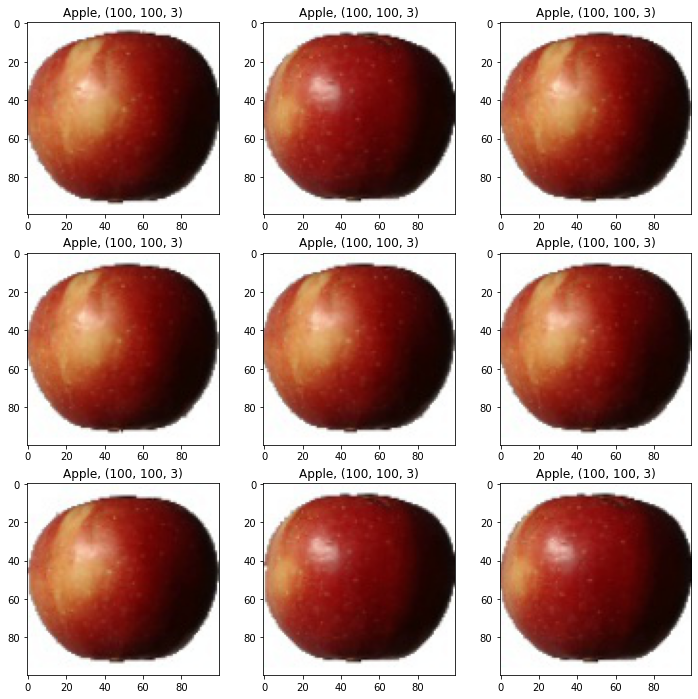

In [10]:
Apple = list(export_dir.glob('train/Apple/*'))
plot_sample_images_from_dir(Apple, "Apple", 3, 3)

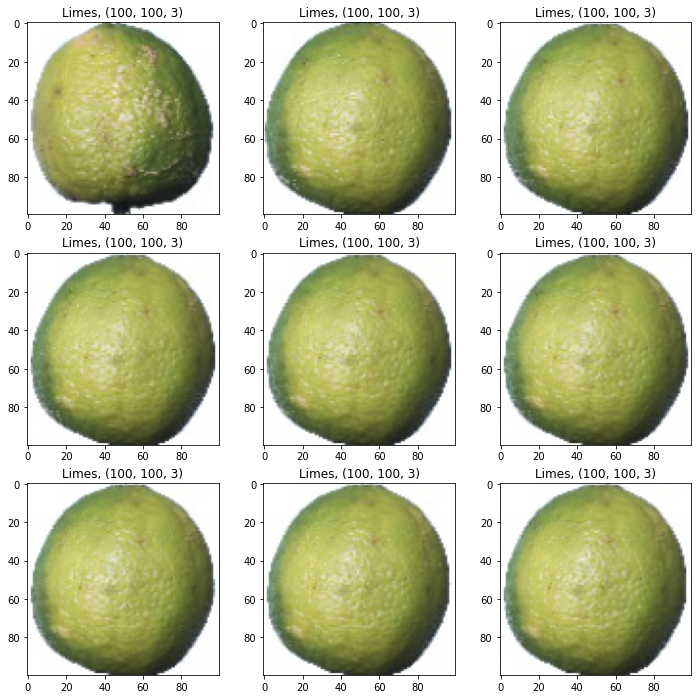

In [11]:
Limes = list(export_dir.glob('train/Limes/*'))
plot_sample_images_from_dir(Limes, "Limes", 3, 3)

In [12]:
# checking shape of the pictures
example_img = mpimg.imread(str(Limes[0]))
print(example_img.shape)
#example_img

(100, 100, 3)


## Preprocessing data

### Defining hyperparameter

In [13]:
batch_size = 32
img_height = 100  
img_width = 100   
input_shape = (img_height, img_width, 1)

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "../export/train",
  validation_split=0.1,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4754 files belonging to 5 classes.
Using 4279 files for training.


In [15]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "../export/train",
  validation_split=0.1,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4754 files belonging to 5 classes.
Using 475 files for validation.


In [16]:
class_names = np.array(train_ds.class_names)
print(class_names)

['Apple' 'Apricot' 'Limes' 'Orange' 'Pear']


## Check distribution of the data

In [17]:
def count_datapoints(directory, class_names):
  base_path_train = f'{data_dir}/{directory}/'

  dict_counts = {}
  for item in class_names:
    dir = os.path.join(base_path_train, item)
    no_examples = len([name for name in os.listdir(dir) if os.path.isfile(os.path.join(dir, name))])
    dict_counts[item] = no_examples

  dict_counts_df = pd.DataFrame(dict_counts.items(), columns=['class', 'no_examples'])
  dict_counts_df['delta'] = (dict_counts_df['no_examples'] - dict_counts_df['no_examples'].median())/dict_counts_df['no_examples'].median()
  return dict_counts_df

In [18]:
dict_counts_train_df = count_datapoints('export/train', class_names)
dict_counts_test_df = count_datapoints('export/test', class_names)

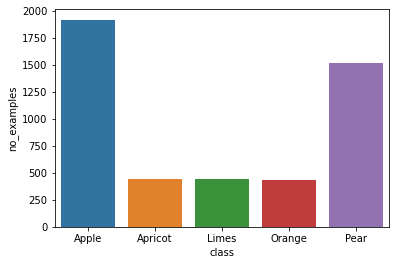

In [19]:
# Histogramm für Trainingsdatensatz
fig_train = sns.barplot(data=dict_counts_train_df, x='class', y='no_examples')
fig_train;

<AxesSubplot:xlabel='class', ylabel='delta'>

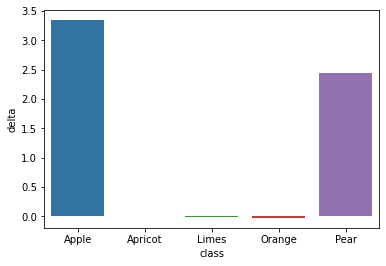

In [20]:
# Histogramm für Deltas im Trainingsdatensatz
fig_train_delta = sns.barplot(data=dict_counts_train_df, x='class', y='delta')
fig_train_delta

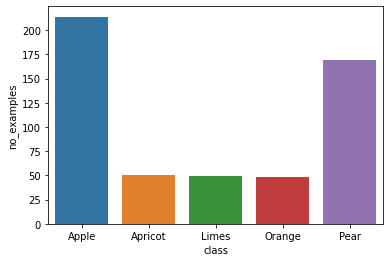

In [21]:
# Histogramm für Testdatensatz
fig_test = sns.barplot(data=dict_counts_test_df, x='class', y='no_examples')
fig_test;

<AxesSubplot:xlabel='class', ylabel='delta'>

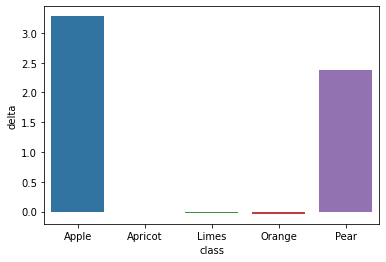

In [22]:
# Histogramm für Deltas im Trainingsdatensatz
fig_test_delta = sns.barplot(data=dict_counts_test_df, x='class', y='delta')
fig_test_delta

**Data set is imbalanced**  
The training dataset is imbalanced and contains significantly more images of apples and pears than of limes, oranges and apricots.  
This is due to the fact that apples and pears contain many varieties with different appearances.   
However, this can lead to a preference of the model for the labels apple or pear. In this respect, it should be checked whether the data set needs to be balanced.  

### Print samples

In [23]:
def plot_sample_images_from_dataset(img_batch, rows, cols):
  count = 0
  
  fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(12,12))

  for images, labels in img_batch:
    for i in range(rows):
      for j in range(cols):
        axes[i, j].imshow(images[count].numpy().astype("uint8"))
        axes[i, j].set_title(f"{class_names[labels[count]]}, {images[count].shape}")
        count+=1
  plt.show()

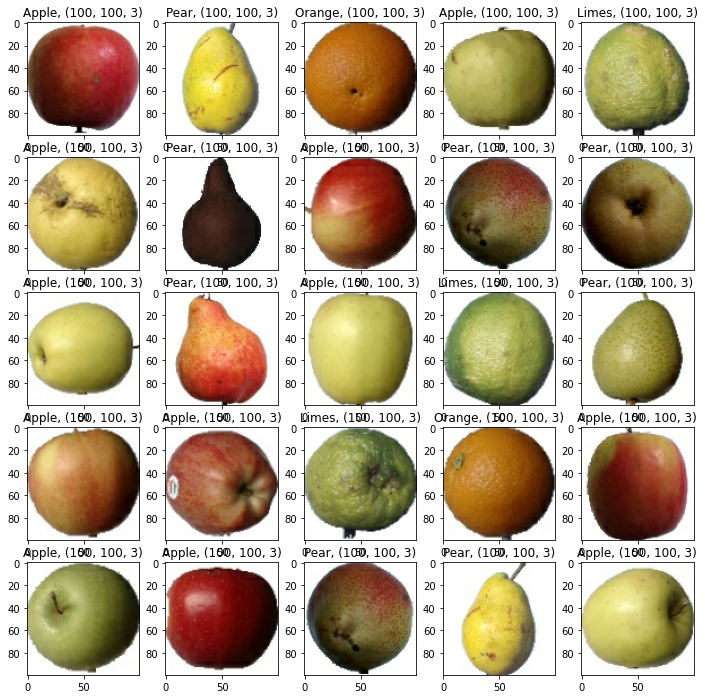

In [24]:
plot_sample_images_from_dataset(train_ds.take(1), 5, 5)

In [25]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 100, 100, 3)
(32,)


## Configuring the data sets for better performance in training

In [26]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Normalising the data

In [27]:
normalization_layer = layers.Rescaling(1./255)

## Creating the model architecture 

In [28]:
num_classes = len(class_names)

# model = Sequential([
#   layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes)
# ])

## Hyperparameter Tuning

In [29]:
def create_model(hp):
  hp_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001])

  model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
  ])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  return model


In [30]:
tuner = kt.RandomSearch(create_model, objective='accuracy', max_trials=3)

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json


In [31]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [32]:
#tuner.search(train_ds, epochs=2, callbacks=[stop_early])
tuner.search(train_ds, epochs=2)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal learning rate for the optimizer
is 0.001.



## Compile model

In [33]:
model = tuner.hypermodel.build(best_hps)

In [34]:
shutil.rmtree(os.path.join(root_dir, 'tensorboard_1'), ignore_errors=True, onerror=None)
os.makedirs(os.path.join(root_dir, 'tensorboard_1'))

In [35]:
log_dir = "../tensorboard_1/"  + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "_without-reg"
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

## Visualize model

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)       

## Start training and enter parameters

In [37]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=tensorboard_callback
)

Epoch 1/10
134/134 [==============================] - 10s 23ms/step - loss: 0.3022 - accuracy: 0.8857 - val_loss: 0.0423 - val_accuracy: 0.9937
Epoch 2/10
134/134 [==============================] - 2s 15ms/step - loss: 0.0188 - accuracy: 0.9958 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 3/10
134/134 [==============================] - 2s 16ms/step - loss: 0.0262 - accuracy: 0.9907 - val_loss: 0.0878 - val_accuracy: 0.9621
Epoch 4/10
134/134 [==============================] - 2s 17ms/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 3.2607e-04 - val_accuracy: 1.0000
Epoch 5/10
134/134 [==============================] - 2s 13ms/step - loss: 2.4645e-04 - accuracy: 1.0000 - val_loss: 2.0483e-04 - val_accuracy: 1.0000
Epoch 6/10
134/134 [==============================] - 2s 13ms/step - loss: 1.1701e-04 - accuracy: 1.0000 - val_loss: 1.3222e-04 - val_accuracy: 1.0000
Epoch 7/10
134/134 [==============================] - 2s 14ms/step - loss: 8.6723e-05 - accuracy: 1.0000 - val_loss: 9.60

## Monitor training results with TensorBoard

In [38]:
%tensorboard --logdir "../tensorboard_1"

Reusing TensorBoard on port 6006 (pid 3032), started 1 day, 0:08:28 ago. (Use '!kill 3032' to kill it.)

## Predictions with new, unseen data

### Prediction with a sample image of the "Orange" class

In [39]:
orange_path = os.listdir("../export/test/Orange")[10]
orange_path = "../export/test/Orange/" + orange_path

img = tf.keras.utils.load_img(
    orange_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Orange with a 100.00 percent confidence.


### Prediction with a sample image of the "Apricot" class

In [40]:
apricot_path = os.listdir("../export/test/Apricot")[10]
apricot_path = "../export/test/Apricot/" + apricot_path

img = tf.keras.utils.load_img(
    apricot_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Apricot with a 100.00 percent confidence.


### Predictions with a batch of images and evaluation

In [41]:
data_dir_test = pathlib.Path("../export/test")

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 530 files belonging to 5 classes.


In [42]:
for image_batch, labels_batch in test_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 100, 100, 3)
(32,)


In [43]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [44]:
cm = confusion_matrix(labels_batch, predicted_id)

In [45]:
def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

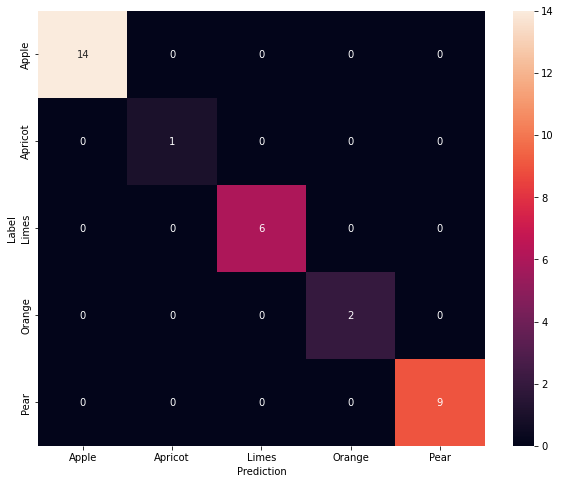

In [46]:
show_confusion_matrix(cm, class_names)

In [47]:
print(classification_report(labels_batch, predicted_id, target_names=class_names))

              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00        14
     Apricot       1.00      1.00      1.00         1
       Limes       1.00      1.00      1.00         6
      Orange       1.00      1.00      1.00         2
        Pear       1.00      1.00      1.00         9

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



### Illustration of the predictions using a batch of images

In [48]:
def plot_inferences(image_batch, predicted_labels, rows, cols):
  count = 0

  fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(12,12))

  for i in range(rows):
    for j in range(cols):
      img = image_batch[count]/255
      axes[i, j].imshow(img)
      axes[i, j].set_title(f"{predicted_labels[count].title()}, {img.shape}")
      count+=1
  fig.suptitle("Prediction Fruits", fontsize=18)
  plt.show()

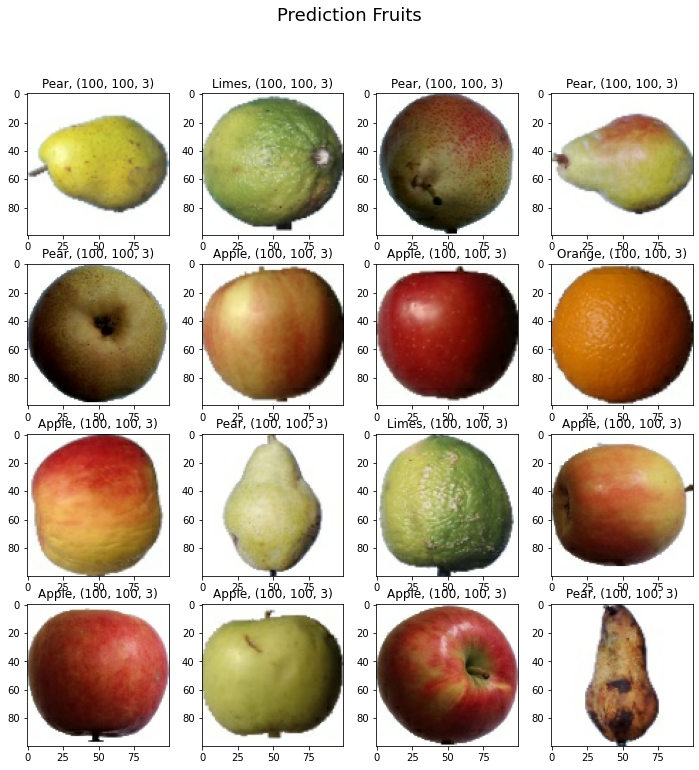

In [49]:
plot_inferences(image_batch, predicted_label_batch, 4, 4)

## Testing predictions for self-created photos

In [50]:
batch_size = 32
img_height = 100  
img_width = 100   
input_shape = (img_height, img_width, 1)

In [51]:
data_dir_test_photos = pathlib.Path("../self-photographed_images_fruits")

test_photos_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test_photos,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 34 files belonging to 5 classes.


In [52]:
class_names_photos = np.array(test_photos_ds.class_names)
print(class_names)

['Apple' 'Apricot' 'Limes' 'Orange' 'Pear']


In [53]:
for image_batch_photos, labels_batch_photos in test_photos_ds:
  print(image_batch_photos.shape)
  print(labels_batch_photos.shape)
  break

(32, 100, 100, 3)
(32,)


In [54]:
predicted_batch_photos = model.predict(image_batch_photos)
predicted_id = tf.math.argmax(predicted_batch_photos, axis=-1)
predicted_label_batch = class_names_photos[predicted_id]

In [55]:
cm = confusion_matrix(labels_batch, predicted_id)

In [56]:
def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

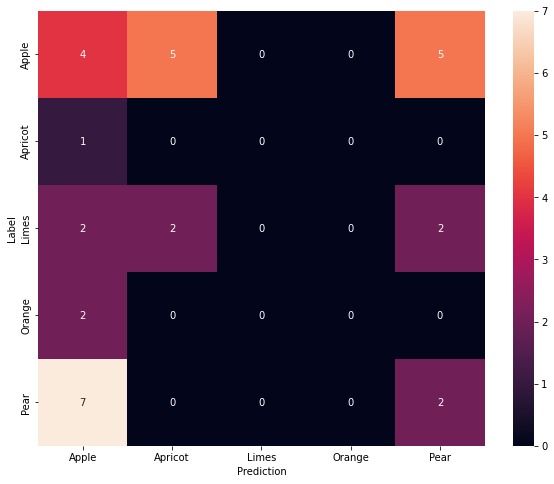

In [57]:
show_confusion_matrix(cm, class_names_photos)

In [58]:
print(classification_report(labels_batch, predicted_id, target_names=class_names))

              precision    recall  f1-score   support

       Apple       0.25      0.29      0.27        14
     Apricot       0.00      0.00      0.00         1
       Limes       0.00      0.00      0.00         6
      Orange       0.00      0.00      0.00         2
        Pear       0.22      0.22      0.22         9

    accuracy                           0.19        32
   macro avg       0.09      0.10      0.10        32
weighted avg       0.17      0.19      0.18        32



In [59]:
def plot_inferences(image_batch_photos, predicted_labels_photos, rows, cols):
  count = 0

  fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(12,12))

  for i in range(rows):
    for j in range(cols):
      img = image_batch_photos[count]/255
      axes[i, j].imshow(img)
      axes[i, j].set_title(f"{predicted_labels_photos[count].title()}, {img.shape}")
      count+=1
  fig.suptitle("Prediction Fruits - Self Photographed Images", fontsize=18)
  plt.show()

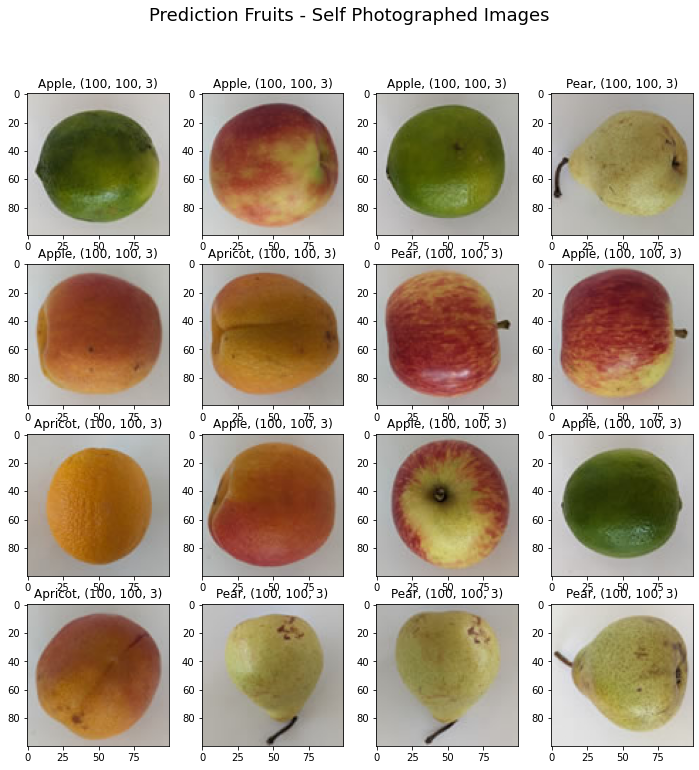

In [60]:
plot_inferences(image_batch_photos, predicted_label_batch, 4, 4)